In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_absolute_percentage_error

In [61]:
import logging
import cmdstanpy

# Устанавливаем уровень логирования для cmdstanpy на WARNING, чтобы скрыть INFO сообщения
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [5]:
df = pd.read_csv('google-data.csv')

In [7]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
3,2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
4,2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900
...,...,...,...,...,...,...,...
1254,2017-12-22,1061.109985,1064.199951,1059.439941,1060.119995,1060.119995,755100
1255,2017-12-26,1058.069946,1060.119995,1050.199951,1056.739990,1056.739990,760600
1256,2017-12-27,1057.390015,1058.369995,1048.050049,1049.369995,1049.369995,1271900
1257,2017-12-28,1051.599976,1054.750000,1044.770020,1048.140015,1048.140015,837100


In [9]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
df['Date'].min(), df['Date'].max()

('2013-01-02', '2017-12-29')

In [13]:
cols = ['Open', 'High', 'Low', 'Volume', 'Adj Close']
df.drop(cols, axis=1, inplace=True)
df = df.sort_values('Date')

In [15]:
df

,Date,Close
0,2013-01-02,359.288177
1,2013-01-03,359.496826
2,2013-01-04,366.600616
3,2013-01-07,365.001007
4,2013-01-08,364.280701
...,...,...
1254,2017-12-22,1060.119995
1255,2017-12-26,1056.739990
1256,2017-12-27,1049.369995
1257,2017-12-28,1048.140015


In [17]:
df = df.rename(columns={'Date': 'ds', 'Close': 'y'})

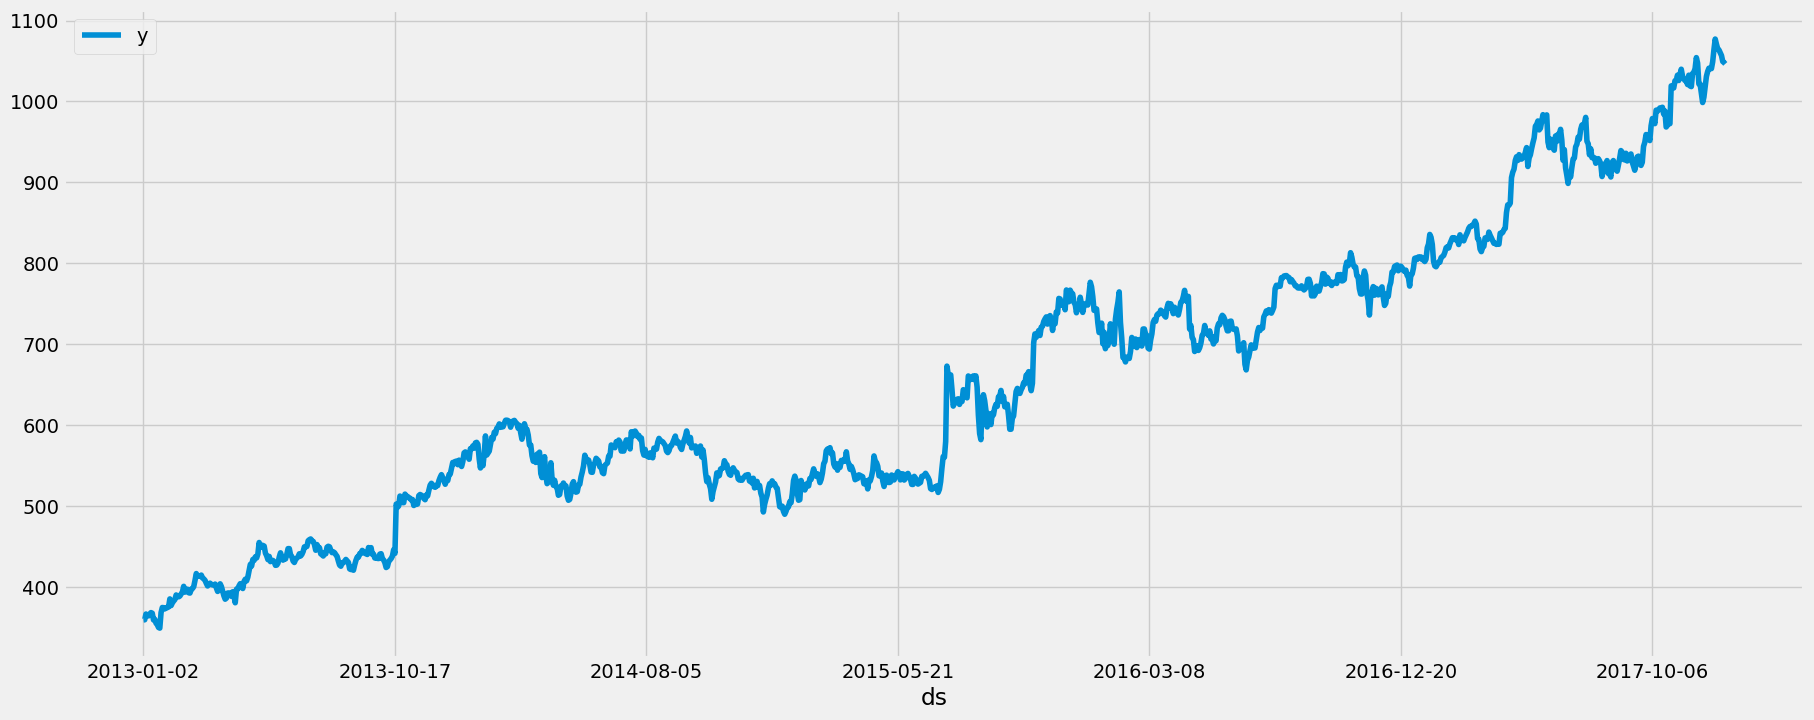

In [19]:
df.plot(x='ds',y='y', figsize=(20, 8))
plt.show()

In [21]:
model = Prophet(interval_width=0.95)

In [23]:
model.fit(df)
google_forecast = model.make_future_dataframe(periods=100, freq='D',include_history= False)
google_forecast

01:25:20 - cmdstanpy - INFO - Chain [1] start processing
01:25:21 - cmdstanpy - INFO - Chain [1] done processing


,ds
0,2017-12-30
1,2017-12-31
2,2018-01-01
3,2018-01-02
4,2018-01-03
...,...
95,2018-04-04
96,2018-04-05
97,2018-04-06
98,2018-04-07


In [25]:
google_forecast = model.predict(google_forecast)

In [27]:
forecast_start_date = '2017-12-29'
google_forecast_filtered = google_forecast[google_forecast['ds'] >= forecast_start_date]

In [29]:
mean_absolute_percentage_error(df['y'].iloc[:100], google_forecast['yhat'])

1.7115634256671997

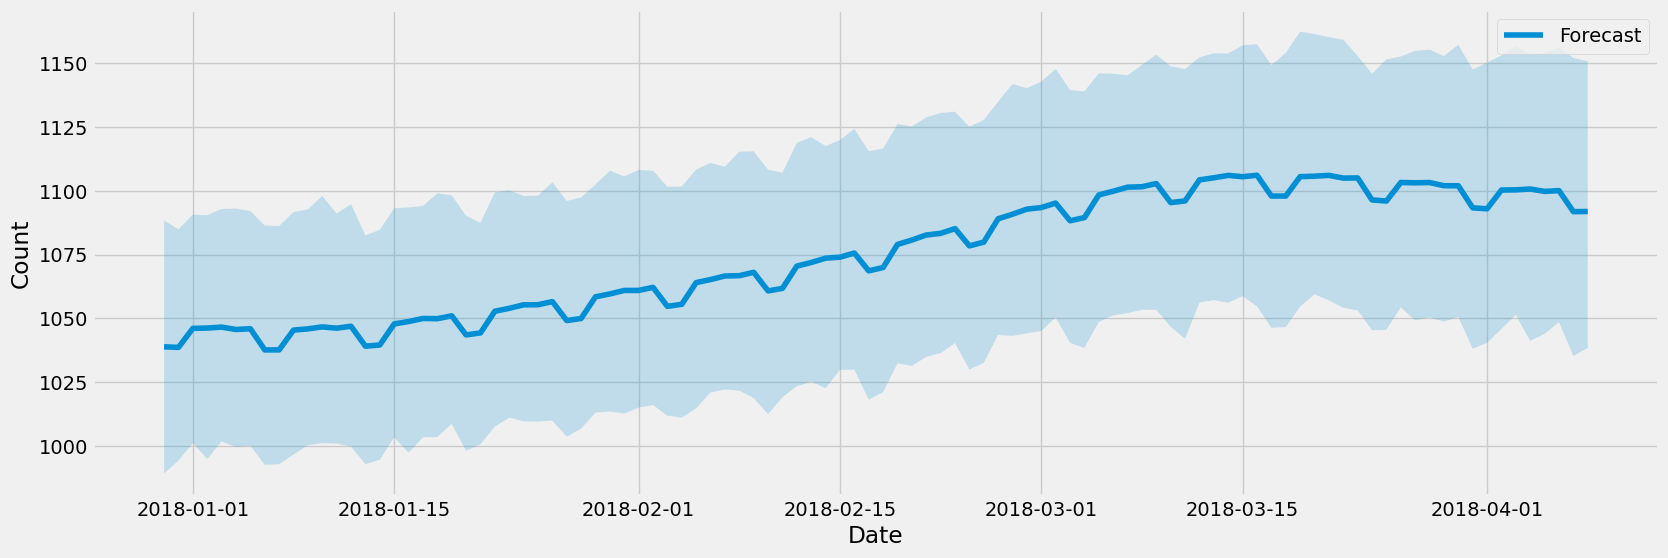

In [31]:
plt.figure(figsize=(18, 6))
plt.plot(google_forecast_filtered['ds'], google_forecast_filtered['yhat'], label='Forecast')
plt.fill_between(google_forecast_filtered['ds'], google_forecast_filtered['yhat_lower'], google_forecast_filtered['yhat_upper'], alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

## Tuning the model

In [97]:
params = {
    'changepoint_prior_scale': (0.001, 1.0),  
    'seasonality_prior_scale': (0.001, 20),
    'holidays_prior_scale': (0.001, 20)
}

In [119]:
def prophet_cv(changepoint_prior_scale, seasonality_prior_scale, holidays_prior_scale):
    model = Prophet(
        interval_width=0.95,
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale
    )
    
    model.fit(df)
    
    future = model.make_future_dataframe(periods=100, freq='D')
    forecast = model.predict(future)
    
    mape = mean_absolute_percentage_error(df['y'], forecast['yhat'][:len(df)])
    
    return -mape

In [121]:
optimizer = BayesianOptimization(
    f=prophet_cv,
    pbounds=params,
    random_state=42,
)

In [123]:
optimizer.maximize(
    init_points=10,
    n_iter=30,
)

|   iter    |  target   | change... | holida... | season... |
-------------------------------------------------------------
| 1         | -0.02131  | 0.3752    | 19.01     | 14.64     |
| 2         | -0.02115  | 0.5991    | 3.121     | 3.121     |
| 3         | -0.02863  | 0.05903   | 17.32     | 12.02     |
| 4         | -0.02107  | 0.7084    | 0.4127    | 19.4      |
| 5         | -0.02104  | 0.8326    | 4.248     | 3.637     |
| 6         | -0.02194  | 0.1842    | 6.086     | 10.5      |
| 7         | -0.02122  | 0.4325    | 5.825     | 12.24     |
| 8         | -0.02245  | 0.1404    | 5.844     | 7.328     |
| 9         | -0.02119  | 0.4566    | 15.7      | 3.994     |
| 10        | -0.02115  | 0.5147    | 11.85     | 0.93      |
| 11        | -0.02138  | 0.3422    | 19.99     | 16.97     |
| 12        | -0.02451  | 0.08144   | 15.19     | 0.6707    |
| 13        | -0.02138  | 0.3402    | 4.888     | 1.382     |
| 14        | -0.02112  | 0.6063    | 9.168     | 1.389     |
| 15    

In [124]:
print(optimizer.max)

{'target': -0.02102255453071339, 'params': {'changepoint_prior_scale': 1.0, 'holidays_prior_scale': 4.879336039101136, 'seasonality_prior_scale': 17.586047176207916}}


In [125]:
best_params = optimizer.max['params']

# Создаем и обучаем модель Prophet с лучшими параметрами
best_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale']
)
best_model.fit(df)

In [126]:
google_forecast1 = best_model.make_future_dataframe(periods=100, freq='D',include_history= False)
google_forecast1

,ds
0,2017-12-30
1,2017-12-31
2,2018-01-01
3,2018-01-02
4,2018-01-03
...,...
95,2018-04-04
96,2018-04-05
97,2018-04-06
98,2018-04-07


In [127]:
google_forecast1 = best_model.predict(google_forecast1)

In [128]:
forecast_start_date = '2017-12-29'
google_forecast_filtered1 = google_forecast1[google_forecast1['ds'] >= forecast_start_date]

In [129]:
mean_absolute_percentage_error(df['y'].iloc[:100], google_forecast1['yhat'])

1.7409900911278244

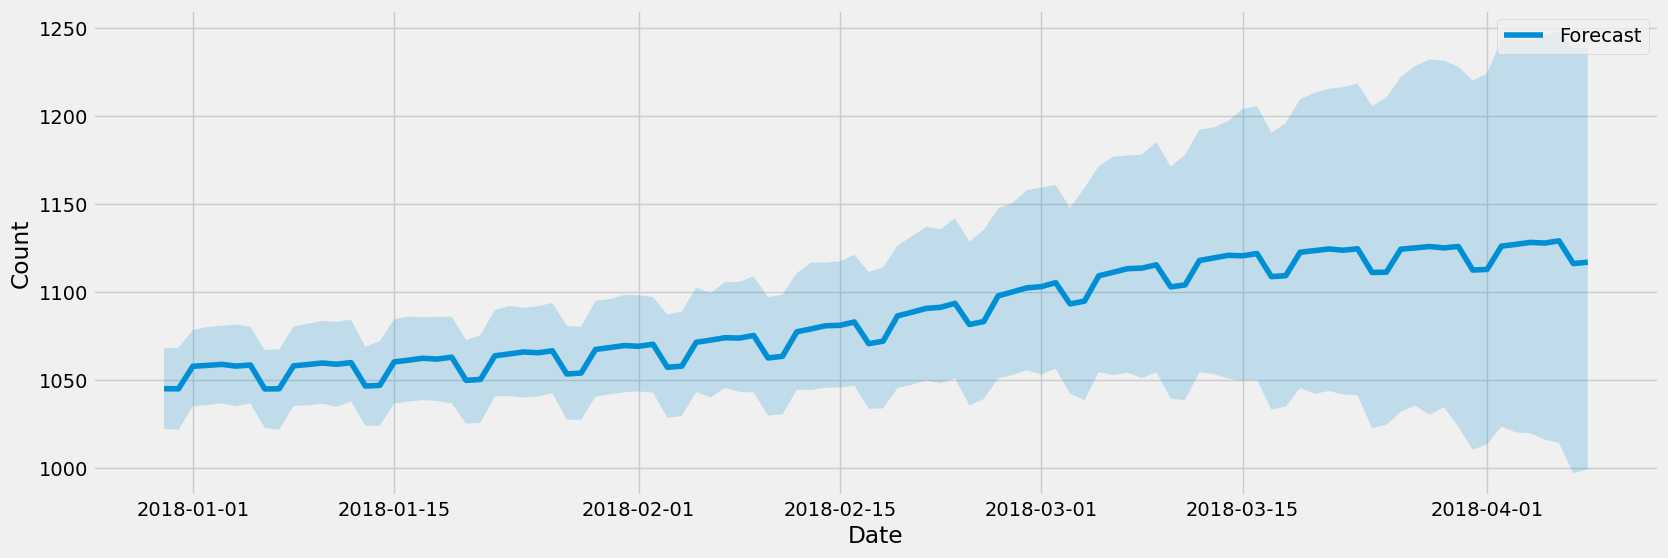

In [117]:
plt.figure(figsize=(18, 6))
plt.plot(google_forecast_filtered1['ds'], google_forecast_filtered1['yhat'], label='Forecast')
plt.fill_between(google_forecast_filtered1['ds'], google_forecast_filtered1['yhat_lower'], google_forecast_filtered1['yhat_upper'], alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()